# Simulations - splitting real data

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import scanpy as sc
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import os,sys,inspect
# setting the path to source
# sys.path.insert(0,os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))) + '/source') 
sys.path.append('../source') 

# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
# import PathwayAnalyser

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import normalize
import multiprocessing

In [23]:
import scanpy as sc
import cellrank as cr
from cellrank.datasets import pancreas_preprocessed

## Test on pancreas dataset

In [3]:
# pip install git+https://github.com/theislab/cellrank

In [5]:
adata = pancreas_preprocessed()
adata.obs['time'] = adata.obs['dpt_pseudotime'].copy()
adata.X = adata.X.toarray()

Get beta lineage drivers using Cellrank

In [6]:
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

k = 0.8 * vk + 0.2 * ck
g = cr.estimators.GPCCA(k)

g.compute_schur(n_components=4)
g.compute_macrostates(cluster_key="clusters")
g.set_terminal_states_from_macrostates(["Alpha", "Beta", "Epsilon"])
g.compute_absorption_probabilities()

beta_drivers = g.compute_lineage_drivers(lineages="Beta")

  0%|          | 0/2531 [00:00<?, ?cell/s]

  0%|          | 0/2531 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/3 [00:00<?, ?/s]

In [7]:
# keep only differentiation 2 beta lineage
adata = adata[adata.obs['clusters'].isin(['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta'])].copy()

/home/jovyan/my-conda-envs/genes2genes-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


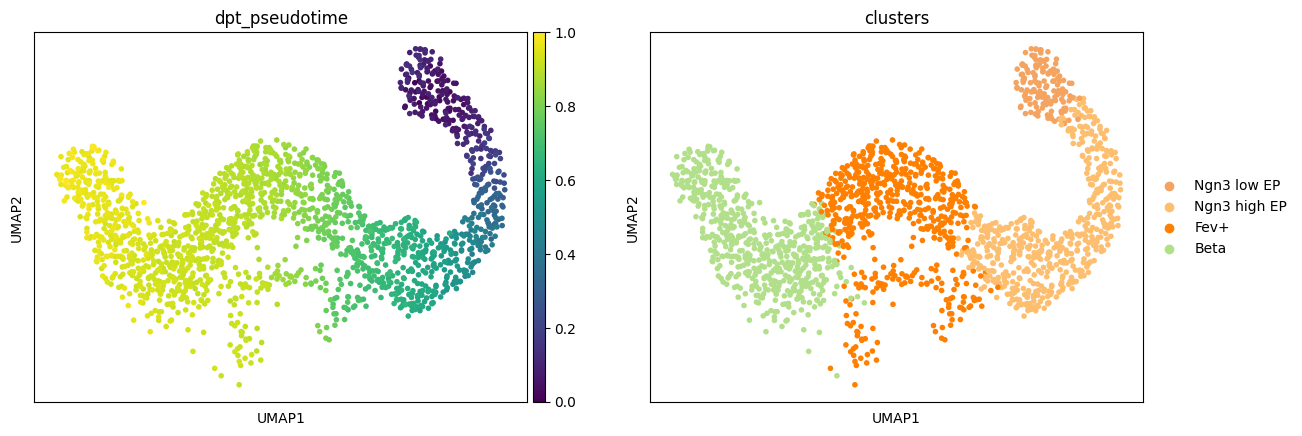

In [8]:
sc.pl.umap(adata, color=['dpt_pseudotime', 'clusters'])

In [77]:
adata.var = pd.concat([adata.var, beta_drivers], axis=1)

In [79]:
adata.var['simulation_gene'] = beta_drivers['Beta_qval'] < 0.01

In [80]:
## Save object
adata.write_h5ad('./data/match_accuracy_pancreas.h5ad')

In [24]:
adata = sc.read_h5ad('./data/match_accuracy_pancreas.h5ad')

## Match/mismatch accuracy

In [91]:
import TimeSeriesPreprocessor.Utils 

ModuleNotFoundError: No module named 'TimeSeriesPreprocessor.Utils'; 'TimeSeriesPreprocessor' is not a package

In [106]:


def simulate_alignment2(adata, true_align_string, 
                       frac_query = 0.5,
                       seed=42352,
                       gene = 'Msi1',
                       n_stds = 1):
    np.random.seed(seed)
    n_bins=len(true_align_string)
    adata.obs['time_bins'] = pd.cut(adata.obs['time'], n_bins).astype('category').cat.codes
    q_cells= np.array([])

    ## Split in ref and query
    for i,b in enumerate(true_align_string):
        n_cells = sum(adata.obs['time_bins'] == i)
        q_cells_bin = np.random.choice(adata.obs_names[adata.obs['time_bins'] == i], size=int(np.round(n_cells*frac_query)), replace=False)
        q_cells = np.hstack([q_cells, q_cells_bin])

    adata_query = adata[q_cells].copy()
    adata_ref = adata[~adata.obs_names.isin(q_cells)].copy()
    
    ## Calculate shift for insertion
    X_query = adata_query.X.copy()
    X_gene = X_query[:,adata_query.var_names == gene]
    ins_shift = n_stds*X_gene.std()
    
    for i,b in enumerate(true_align_string):
        bcells = adata_query.obs_names[adata_query.obs['time_bins'] == i]
        if b == 'D': ## delete cells
            adata_query = adata_query[~adata_query.obs_names.isin(bcells)].copy()
        if b == 'I': # change values for gene expression            
            X_query = adata_query.X.copy()
            X_gene = X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene]
            X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene] = X_gene + ins_shift
            adata_query.X = X_query.copy()
    
    # Algorithm expect time spanning from 0 to 1
    adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(adata_ref.obs['time'].values)
    adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(adata_query.obs['time'].values)
    # adata_query.obs.loc[adata_query.obs['time'].idxmax(), 'time'] = 1.0
    return(adata_ref, adata_query)

def make_align_string(mm_type, mm_start = 10, n_bins = 40, mm_size=10):
    mm_ixs = range(mm_start, mm_start+mm_size)
    true_align_string = ''.join([mm_type if i in mm_ixs else 'M' for i in range(n_bins)])
    return(true_align_string)

def alignment_viz(aligner, al_obj):
    # plt.subplots(1,2,figsize=(10,3))
    # plt.subplot(1,2,1)
    # al_obj.plotTimeSeries(aligner, plot_cells=True)
    # plt.subplot(1,2,2)
    # al_obj.plotTimeSeriesAlignment()
    print(al_obj.al_visual)
    
def predict_alignment(adata_ref, adata_query, gene, n_bins=40):
    gene_list = adata_ref.var_names 
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE = 0.1
    al_obj = aligner.align_single_pair(gene)
    alignment_viz(aligner, al_obj)
    return(al_obj)

def get_ref_aling_str(al_obj):
    ref_ixs = (al_obj.al_visual.split('\n')[1]).split(' Reference')[0]
    al_str = al_obj.alignment_str
    ref_aling_str = ''.join([al_str[i] for i,p in enumerate(ref_ixs) if p!=' ' and al_str[i] != 'V'])
    return(ref_aling_str)


def run_match_accuracy(params):
    adata, gene, align_params, save_aligner = params
    match_dict = {'D':'mismatch', 'I':'mismatch', 'M':'match', 'V':'match', 'W':'match'}
    true_align_string = make_align_string(**align_params)
    rdata, qdata = simulate_alignment2(adata, true_align_string, gene=gene)
    al_obj = predict_alignment(rdata, qdata, gene=gene)
    if save_aligner:
        with open(f'./data/aligner_{gene}.{align_params["mm_type"]}.size{str(align_params["mm_size"])}.pkl', 'wb') as f:
            pickle.dump(al_obj, f)
    true_ref_align_str = get_ref_aling_str(al_obj)

    # get mismatch accuracy
    outcome_df = pd.DataFrame([(i, match_dict[true_align_string[i]], match_dict[c]) for i,c in enumerate(get_ref_aling_str(al_obj) )],
                 columns=['position', 'true', 'predicted']
                )
    outcome_df['correct'] = outcome_df['true'] == outcome_df['predicted']
    accuracy = outcome_df['correct'].sum()/outcome_df['correct'].shape[0]
    outcome_df['accuracy'] = accuracy
    outcome_df['gene'] = gene
    for p in align_params.keys():
        outcome_df[p] = align_params[p]
    outcome_df = outcome_df[list(align_params.keys()) + ['gene', 'accuracy']].drop_duplicates()
    return(outcome_df)

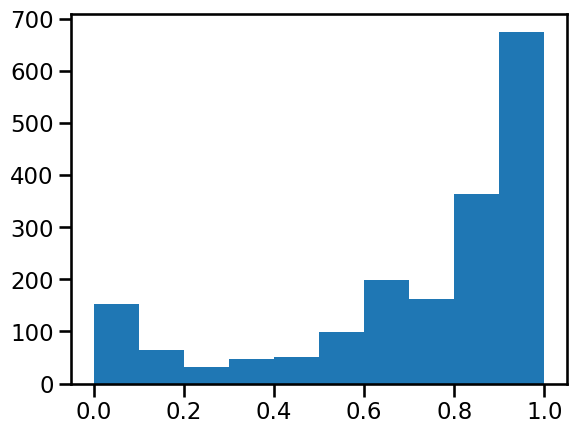

In [107]:
plt.hist(adata.obs['time']);
plt.show()

In [319]:
g = 'Maob'
match_dict = {'D':'mismatch', 'I':'mismatch', 'M':'match', 'V':'match', 'W':'match'}
true_align_string = make_align_string(mm_type="I", mm_start = 0, n_bins = 40, mm_size=5)
# rdata, qdata = simulate_alignment2(adata, true_align_string, gene=g,  n_stds = 1)

In [320]:
seed=2022
frac_query=0.5

In [321]:
gene = g

In [322]:
n_stds = 1

In [329]:
np.random.seed(seed)
n_bins=len(true_align_string)
adata.obs['time_bins'] = pd.cut(adata.obs['time'], n_bins).astype('category').cat.codes
q_cells= np.array([])

## Split in ref and query
for i,b in enumerate(true_align_string):
    n_cells = sum(adata.obs['time_bins'] == i)
    q_cells_bin = np.random.choice(adata.obs_names[adata.obs['time_bins'] == i], size=int(np.round(n_cells*frac_query)), replace=False)
    q_cells = np.hstack([q_cells, q_cells_bin])

adata_query = adata[q_cells].copy()
adata_ref = adata[~adata.obs_names.isin(q_cells)].copy()

## Calculate shift for insertion
X_query = adata_query.X.copy()
X_gene = X_query[:,adata_query.var_names == gene]
# ins_shift = n_stds*X_gene.std()

## Find max bin for insertion (using interpolated mean)
aligner = Main.RefQueryAligner(rdata, qdata, gene_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE = 0.1
al_obj = aligner.align_single_pair(gene)
max_bin = np.array(al_obj.S.intpl_means).argmax()
X_insert = adata_query[adata_query.obs['time_bins'] == max_bin, gene].X
mean_shift = X_insert.mean()  + n_stds * X_insert.std() 
std_shift = X_insert.std()

for i,b in enumerate(true_align_string):
    bcells = adata_query.obs_names[adata_query.obs['time_bins'] == i]
    if b == 'D': ## delete cells
        adata_query = adata_query[~adata_query.obs_names.isin(bcells)].copy()
    if b == 'I': # change values for gene expression  
        X_gene = X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene]
        X_ins = np.random.normal(loc=mean_shift, scale=std_shift, size=len(X_gene))
        X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene] = X_ins
        adata_query.X = X_query.copy()

# Algorithm expect time spanning from 0 to 1
adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(adata_ref.obs['time'].values)
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(adata_query.obs['time'].values)
# adata_query.obs.loc[adata_query.obs['time'].idxmax(), 'time'] = 1.0

In [331]:
# al_obj = predict_alignment(rdata, qdata,g)
gene_list = rdata.var_names 
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE = 0.1
al_obj = aligner.align_single_pair(g)
alignment_viz(aligner, al_obj)

012345678901234567890123456789012345678901234567890123 Alignment index 
              0123456789012345678901234567890123456789 Reference index
--------------****************************************
**************-^^^^^^^^^^^^^**************************
01234567890123 333333333333345678901234567890123456789 Query index
IIIIIIIIIIIIIIDWWWWWWWWWWWWWMMMMMMMMMMMMMMMMMMMMMMMMMM 5-state string 


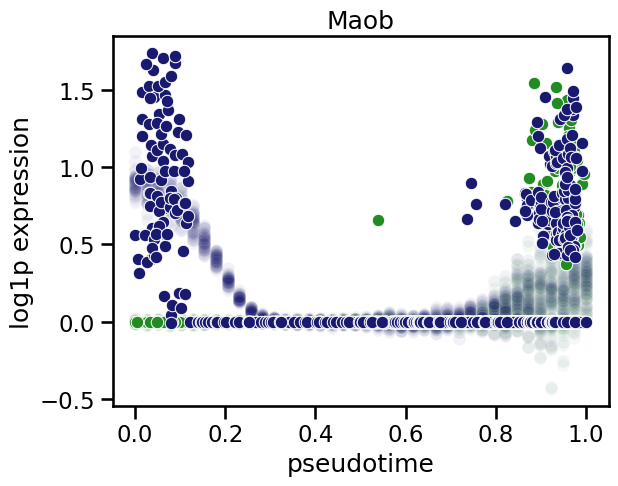

In [333]:
al_obj.plotTimeSeries(aligner, plot_cells=True)
# al_obj.plotTimeSeriesAlignment()
plt.show()

Select genes

N tested genes:  880


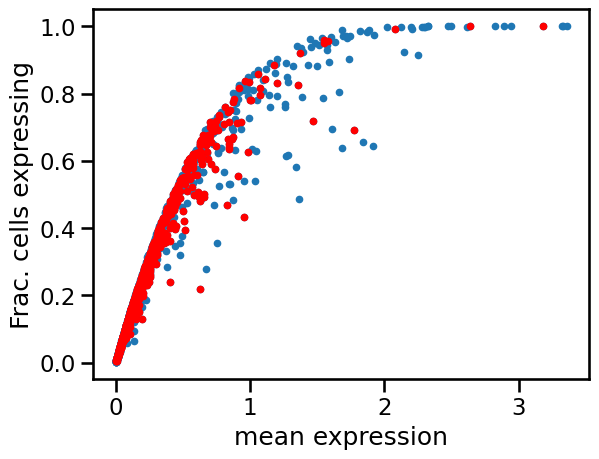

In [21]:
## Exclude genes with very low mean expression on this subset (they get low accuracy because of noise)
mean_gex = adata.X.mean(0)
X_bin = adata.X.copy()
X_bin[X_bin.nonzero()] = 1
frac_cells = X_bin.sum(0)/X_bin.shape[0]
adata.var['mean_gex'] = mean_gex
adata.var['frac_cells'] = frac_cells

plt.plot(mean_gex, frac_cells, '.');
plt.plot(adata.var.loc[adata.var['velocity_genes'], 'mean_gex'],
adata.var.loc[adata.var['velocity_genes'], 'frac_cells'], '.r')
plt.xlabel('mean expression');
plt.ylabel('Frac. cells expressing');

# genes = adata.var_names[(mean_gex > 0.1) & (frac_cells > 0.1)]
genes = adata.var_names[adata.var['velocity_genes']]
print('N tested genes: ', len(genes))

### Simulate deletions

In [138]:
import os
mm_type = 'D'
deletion_out_df = pd.DataFrame()
out_files = [x for x in os.listdir('./data/') if x.startswith(f'match_accuracy_pancreas.{mm_type}.size')]
for f in out_files:
    out_df = pd.read_csv('./data/' + f, index_col=0)    
    deletion_out_df = pd.concat([deletion_out_df, out_df])
# pd.read_csv('./data/match_accuracy_pancreas.D.size0.csv')

In [139]:
match_outcome = deletion_out_df

In [140]:
import seaborn as sns
sns.set_context("talk")
sns.violinplot(data=deletion_out_df, x='mm_size', y='accuracy', cut=True, scale='width');
sns.stripplot(data=deletion_out_df, x='mm_size', y='accuracy', color='black', s=0.5);
plt.ylim(0,1.0);
plt.xlabel("Deletion size (# bins)");
plt.ylabel("Match detection accuracy");

Plot accuracy by gene

In [141]:
acc_matrix = deletion_out_df[['accuracy', 'gene', 'mm_size']].pivot(index='gene', columns='mm_size', values='accuracy')
acc_matrix = acc_matrix.dropna()

## order by mean accuracy
acc_matrix = acc_matrix.loc[acc_matrix.mean(1).sort_values().index]

with plt.rc_context({'figure.figsize':[7,12]}):
    sns.heatmap(acc_matrix);
    plt.xlabel("Deletion size (# bins)");
    plt.ylabel('high mean accuracy <----- gene -----> low mean accuracy')

In [142]:
match_outcome['mean_gex'] = adata.var.loc[match_outcome['gene'], 'mean_gex'].values
match_outcome['frac_cells'] = adata.var.loc[match_outcome['gene'], 'frac_cells'].values
match_outcome['lin_driver'] = np.abs(adata.var.loc[match_outcome['gene'], 'Beta_corr'].values)

In [143]:
acc_matrix

mm_size,0,1,3,5,10,15,20
gene,,,,,,,
Gpr179,0.00,0.02,0.06,0.10,0.20,0.550,0.40
Pde3b,0.68,0.64,0.58,0.58,0.64,0.625,0.60
Ptpn3,0.56,0.58,0.64,0.68,0.66,0.625,0.68
Pon3,0.62,0.64,0.64,0.68,0.66,0.650,0.62
Akap8l,0.62,0.64,0.70,0.72,0.78,0.625,0.44
...,...,...,...,...,...,...,...
Cnot6l,1.00,0.98,0.98,0.98,0.96,1.000,1.00
Ube2e3,0.98,0.98,0.98,1.00,0.96,1.000,1.00
Smarcc1,1.00,0.98,1.00,1.00,0.98,1.000,0.96


In [144]:
sns.set_context("talk")
# sns.violinplot(data=match_outcome, x='mean_gex', y='accuracy', cut=True, scale='width');
sns.scatterplot(data=match_outcome[match_outcome.mm_size==10], x='frac_cells', y='accuracy', color='black', s=10);

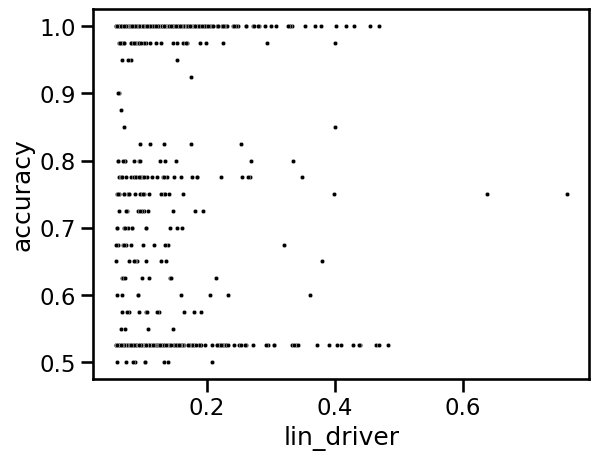

In [15]:
sns.set_context("talk")
# sns.violinplot(data=match_outcome, x='mean_gex', y='accuracy', cut=True, scale='width');
sns.scatterplot(data=match_outcome[match_outcome.mm_size==20], x='lin_driver', y='accuracy', color='black', s=10);

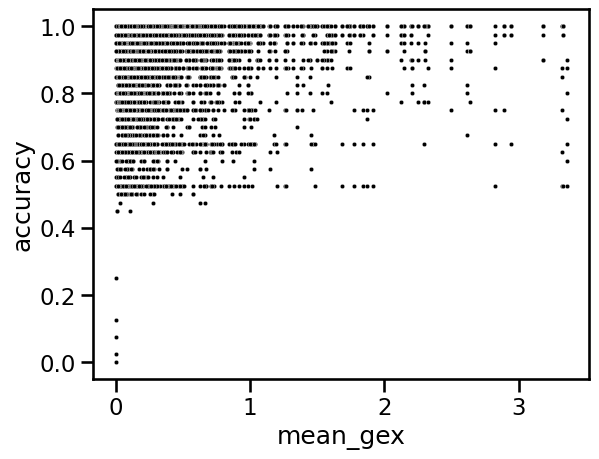

In [16]:
sns.set_context("talk")
# sns.violinplot(data=match_outcome, x='mean_gex', y='accuracy', cut=True, scale='width');
sns.scatterplot(data=match_outcome, x='mean_gex', y='accuracy', color='black', s=10);

### Simulate insertions

In [18]:
import os
mm_type = 'I'
match_outcome = pd.DataFrame()
out_files = [x for x in os.listdir('./data/') if x.startswith(f'match_accuracy_pancreas.{mm_type}.size')]
for f in out_files:
    out_df = pd.read_csv('./data/' + f, index_col=0)    
    match_outcome = pd.concat([match_outcome, out_df])
# pd.read_csv('./data/match_accuracy_pancreas.D.size0.csv')

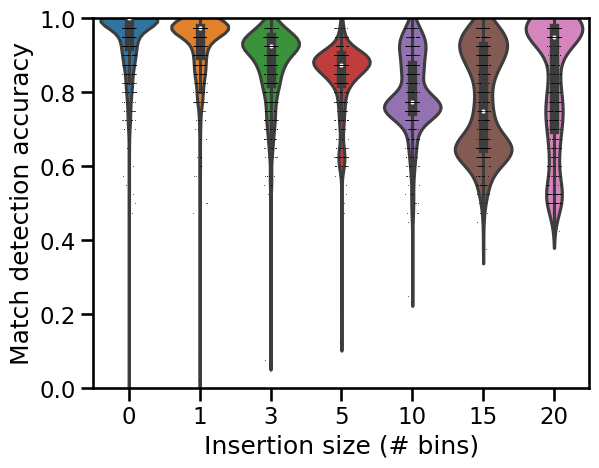

In [19]:
import seaborn as sns
sns.set_context("talk")
sns.violinplot(data=match_outcome, x='mm_size', y='accuracy', cut=True, scale='width');
sns.stripplot(data=match_outcome, x='mm_size', y='accuracy', color='black', s=0.5);
plt.ylim(0,1.0);
plt.xlabel("Insertion size (# bins)");
plt.ylabel("Match detection accuracy");

Plot accuracy by gene

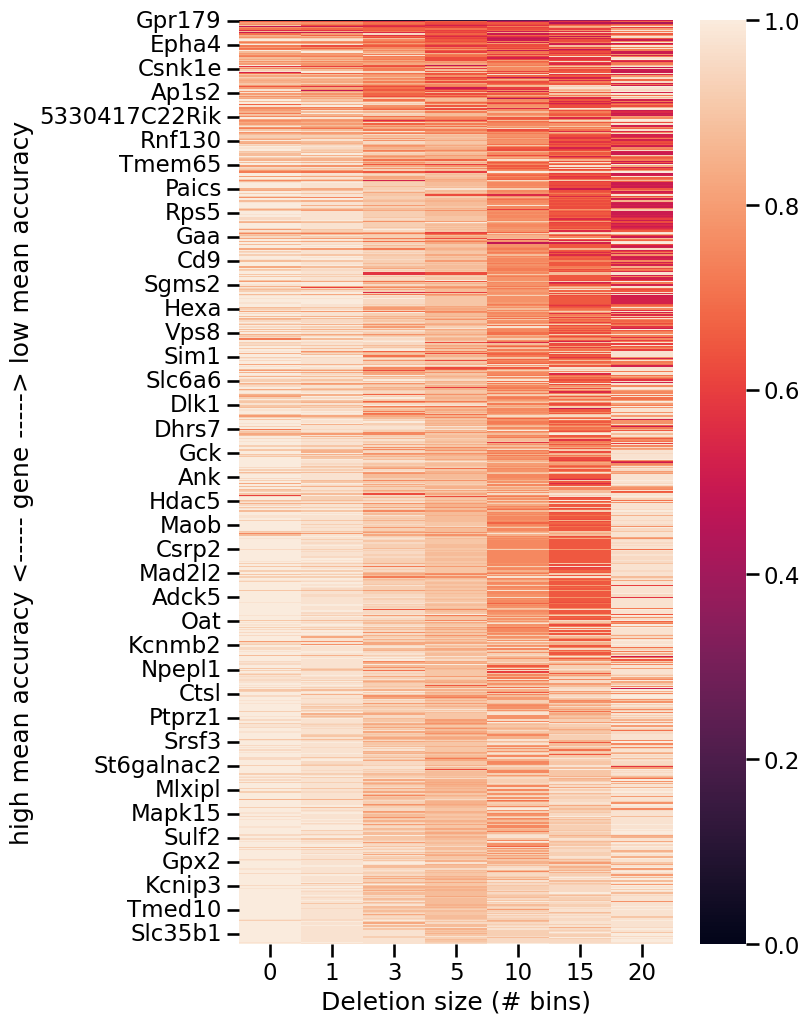

In [20]:
acc_matrix = match_outcome[['accuracy', 'gene', 'mm_size']].pivot(index='gene', columns='mm_size', values='accuracy')
acc_matrix = acc_matrix.dropna()

## order by mean accuracy
acc_matrix = acc_matrix.loc[acc_matrix.mean(1).sort_values().index]

with plt.rc_context({'figure.figsize':[7,12]}):
    sns.heatmap(acc_matrix, vmin=0, vmax=1);
    plt.xlabel("Deletion size (# bins)");
    plt.ylabel('high mean accuracy <----- gene -----> low mean accuracy')

### Make plot

In [32]:
# match_outcome_del = pd.read_csv('./data/match_accuracy_pancreas.deletion.csv', index_col=0)
# match_outcome_ins = pd.read_csv('./data/match_accuracy_pancreas.insertions.csv', index_col=0)

In [25]:
import os
mm_type = 'I'
match_outcome_ins = pd.DataFrame()
out_files = [x for x in os.listdir('./data/') if x.startswith(f'match_accuracy_pancreas.{mm_type}.size')]
for f in out_files:
    out_df = pd.read_csv('./data/' + f, index_col=0)    
    match_outcome_ins = pd.concat([match_outcome_ins, out_df])

mm_type = 'D'    
match_outcome_del = pd.DataFrame()
out_files = [x for x in os.listdir('./data/') if x.startswith(f'match_accuracy_pancreas.{mm_type}.size')]
for f in out_files:
    out_df = pd.read_csv('./data/' + f, index_col=0)    
    match_outcome_del = pd.concat([match_outcome_del, out_df])

In [26]:
match_outcome_ins['frac_mm'] = (match_outcome_ins.mm_size / 40) * 100
match_outcome_del['frac_mm'] = (match_outcome_del.mm_size / 40) * 100

In [32]:
match_outcome_ins[match_outcome_ins['frac_mm'] == 0]['accuracy'].mean() 

0.9497529258777634

In [31]:
match_outcome_del[match_outcome_del['frac_mm'] == 0]['accuracy'].mean() 

0.9497529258777634

In [7]:
np.mean(match_outcome_del[match_outcome_del['frac_mm'] <= 10]['accuracy'])

0.9356653662765496

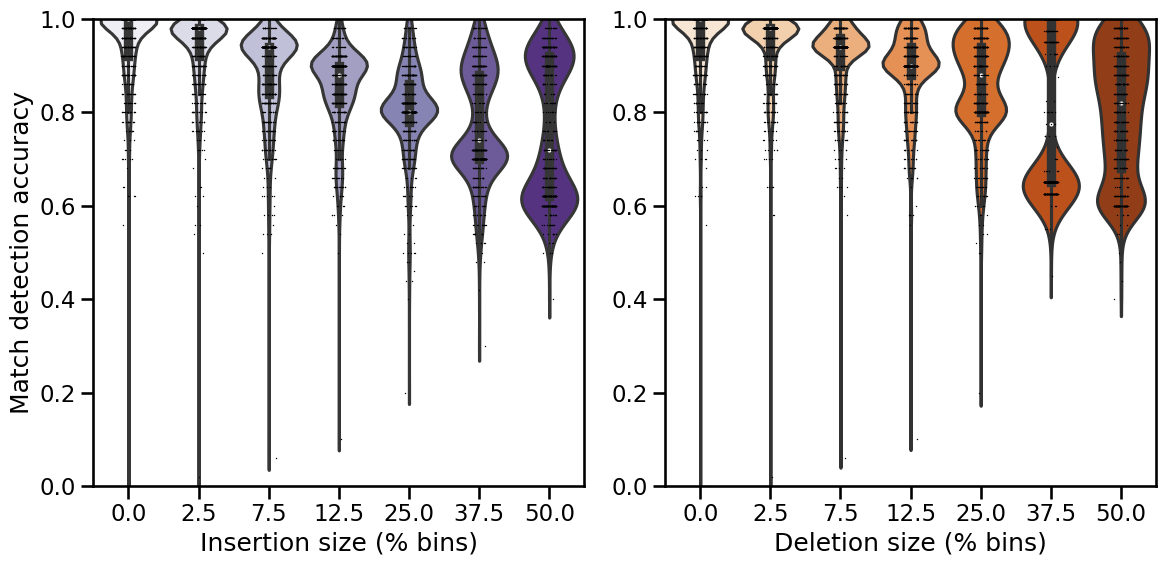

In [8]:
sns.set_context("talk")
with plt.rc_context({'figure.figsize':[12,6]}):
    plt.subplot(1,2,1)
    sns.violinplot(data=match_outcome_ins, x='frac_mm', y='accuracy', cut=True, scale='width', palette='Purples');
    sns.stripplot(data=match_outcome_ins, x='frac_mm', y='accuracy', color='black', s=1);
    plt.ylim(0,1.0);
    plt.xlabel("Insertion size (% bins)");
    plt.ylabel("Match detection accuracy");

    plt.subplot(1,2,2)
    sns.violinplot(data=match_outcome_del,  x='frac_mm', y='accuracy', cut=True, scale='width', palette='Oranges');
    sns.stripplot(data=match_outcome_del, x='frac_mm', y='accuracy', color='black', s=1);
    plt.ylim(0,1.0);
    plt.xlabel("Deletion size (% bins)");
    plt.ylabel("");

    plt.tight_layout()
    plt.savefig('./data/match_accuracy_violins.pdf') 

In [12]:
mean_gex = adata.X.mean(0)
X_bin = adata.X.copy()
X_bin[X_bin.nonzero()] = 1
frac_cells = X_bin.sum(0)/X_bin.shape[0]
adata.var['mean_gex'] = mean_gex
adata.var['frac_cells'] = frac_cells

In [13]:
match_outcome_del['mean_gex'] = adata.var.loc[match_outcome_del['gene'], 'mean_gex'].values
match_outcome_del['frac_cells'] = adata.var.loc[match_outcome_del['gene'], 'frac_cells'].values
match_outcome_del['lin_driver'] = adata.var.loc[match_outcome_del['gene'], 'Beta_corr'].values

match_outcome_ins['mean_gex'] = adata.var.loc[match_outcome_ins['gene'], 'mean_gex'].values
match_outcome_ins['frac_cells'] = adata.var.loc[match_outcome_ins['gene'], 'frac_cells'].values
match_outcome_ins['lin_driver'] = adata.var.loc[match_outcome_ins['gene'], 'Beta_corr'].values

In [14]:
import matplotlib
import scipy.stats 

def plot_scatter(match_outcome_del, cov, s):
    plt.hist2d(match_outcome_del[match_outcome_del.mm_size==s][cov], match_outcome_del[match_outcome_del.mm_size==s]['accuracy'], bins=50,
              norm=matplotlib.colors.LogNorm())
    R2, pval = scipy.stats.pearsonr(match_outcome_del[match_outcome_del.mm_size==s][cov], match_outcome_del[match_outcome_del.mm_size==s]['accuracy'])
    plt.xlabel(cov); plt.ylabel('Accuracy');
    plt.ylim((0,1));
    plt.title(f'R2 = {np.round(R2, 3)}\n(p-val: {np.round(pval,7)})')
    
mm_sizes = match_outcome_del.mm_size.unique()
mm_sizes.sort()
with plt.rc_context({'figure.figsize':[25,6]}):
    for i,s in enumerate(mm_sizes):
        plt.subplot(1,len(mm_sizes), i+1)
        plot_scatter(match_outcome_del, 'mean_gex', s=s);
    plt.tight_layout()
 

In [155]:
   
with plt.rc_context({'figure.figsize':[25,6]}):
    for i,s in enumerate(mm_sizes):
        plt.subplot(1,len(mm_sizes), i+1)
        plot_scatter(match_outcome_del, 'frac_cells', s=s);
    plt.tight_layout()
    

In [156]:
with plt.rc_context({'figure.figsize':[25,6]}):
    for i,s in enumerate(mm_sizes):
        plt.subplot(1,len(mm_sizes), i+1)
        plot_scatter(match_outcome_del, 'lin_driver', s=s);
    plt.tight_layout()

In [157]:
with plt.rc_context({'figure.figsize':[25,6]}):
    for i,s in enumerate(mm_sizes):
        plt.subplot(1,len(mm_sizes), i+1)
        plot_scatter(match_outcome_ins, 'lin_driver', s=s);
    plt.tight_layout()

## Plot interpolated trends for reference


In [15]:
import pickle
alignment_dir = './data/'
os.listdir(alignment_dir)
al_file = 'aligner_Ccdc88a.D.size0.pkl'
# al_files = [os.listdir(alignment_dir) if x.endswith('.D.size0.pkl')]
genes = [x.split('aligner_')[-1].split('.D.size0')[0] for x in os.listdir(alignment_dir) if x.endswith('.D.size0.pkl')]

mean_b = {}
for g in genes:
    al_file = f'aligner_{g}.D.size0.pkl'    
    with open(alignment_dir + al_file, 'rb') as f:
        al = pickle.load(f)
        mean_b[g] = al.S.mean_trend

In [16]:
from sklearn.preprocessing import scale
n_bins = 40
adata.obs['time_bins'] = pd.cut(adata.obs['time'], n_bins).astype('category').cat.codes

In [17]:
def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

In [18]:
acc_matrix = match_outcome_del[['accuracy', 'gene', 'mm_size']].pivot(index='gene', columns='mm_size', values='accuracy')
acc_matrix = acc_matrix.dropna()

## order by mean accuracy
acc_matrix = acc_matrix.loc[acc_matrix.mean(1).sort_values().index]

# mean_b = [adata[adata.obs['time_bins'] == b].X.mean(0) for b in np.arange(n_bins)]
# bin_mean = np.vstack(mean_b).T
bin_mean = pd.DataFrame(np.vstack(mean_b.values()), index=mean_b.keys())
bin_mean = bin_mean.loc[acc_matrix.index]

with plt.rc_context({'figure.figsize':[12,12]}):
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]})
    fig.tight_layout()
    sns.heatmap(acc_matrix, ax=ax[0],cbar_kws = dict(location="top"));
    ax[0].set_xlabel("Deletion size (# bins)");
    ax[0].set_ylabel('high mean accuracy <----- gene -----> low mean accuracy')

    sns.heatmap(scale(bin_mean.T).T, cmap='bwr', ax=ax[1], cbar_kws = dict(location="top"));
    ax[1].set_xlabel("Pseudotime bin");
    
    remove_y_axis(ax[1])
    plt.tight_layout()
    plt.savefig('./data/deletion_heatmap.pdf') 

In [19]:
acc_matrix = match_outcome_ins[['accuracy', 'gene', 'mm_size']].pivot(index='gene', columns='mm_size', values='accuracy')
acc_matrix = acc_matrix.dropna()

## order by mean accuracy
acc_matrix = acc_matrix.loc[acc_matrix.mean(1).sort_values().index]

bin_mean = pd.DataFrame(np.vstack(mean_b.values()), index=mean_b.keys())
bin_mean = bin_mean.loc[acc_matrix.index]


with plt.rc_context({'figure.figsize':[12,12]}):
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]})
    fig.tight_layout()
    sns.heatmap(acc_matrix, ax=ax[0],cbar_kws = dict(location="top"));
    ax[0].set_xlabel("Insertion size (# bins)");
    ax[0].set_ylabel('high mean accuracy <----- gene -----> low mean accuracy')

    sns.heatmap(scale(bin_mean.T).T, cmap='bwr', ax=ax[1], cbar_kws = dict(location="top"));
    ax[1].set_xlabel("Pseudotime bin");
    
    remove_y_axis(ax[1])
    plt.tight_layout()
    plt.savefig('./data/insertion_heatmap.pdf') 

In [20]:
norm_bin_mean = pd.DataFrame(scale(bin_mean.T).T, index=bin_mean.index)
match_outcome_del['bottom_bins_mean'] = norm_bin_mean.loc[match_outcome_del.gene].iloc[:,0:10].mean(1).values
match_outcome_del['mid_bins_mean'] = norm_bin_mean.loc[match_outcome_del.gene].iloc[:,10:20].mean(1).values
match_outcome_del['top_bins_mean'] = norm_bin_mean.loc[match_outcome_del.gene].iloc[:,10:].mean(1).values
match_outcome_del['mm_bins_mean'] = [norm_bin_mean.loc[x['gene'],np.arange(x['mm_start'], x['mm_start']+x['mm_size'])].mean() if x['mm_size'] > 0 else 0 for i,x in match_outcome_del.iterrows()]

match_outcome_ins['bottom_bins_mean'] = norm_bin_mean.loc[match_outcome_ins.gene].iloc[:,0:20].mean(1).values
match_outcome_ins['top_bins_mean'] = norm_bin_mean.loc[match_outcome_ins.gene].iloc[:,20:].mean(1).values
match_outcome_ins['mm_bins_mean'] = [norm_bin_mean.loc[x['gene'],np.arange(x['mm_start'], x['mm_start']+x['mm_size'])].mean() if x['mm_size'] > 0 else 0 for i,x in match_outcome_ins.iterrows()]